In [1]:
# MIT License

# Copyright (c) [2019] [Jayden Booth]

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.


# Import Libraries
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout, concatenate, Layer
from keras.models import Model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set random seeds
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(3)

In [3]:
# Set the defining parameters
# n = n_channel complex numbers (so 2n real numbers)
# k = log2(M), where M is the number of messages to encode
# EbNo is the energy per bit to noise power density

# Encoder Parameters
M = 16
k = np.log2(M)
n_channel = 1
R = k/n_channel
print('M:',M,'\t','n:',n_channel)

# Channel Parameters
EbNo=10.0**(7/10.0)
noise_std = np.sqrt(1/(2*R*EbNo))
num_taps = 1
reyleigh_std = num_taps/np.sqrt(2)

M: 16 	 n: 1


In [4]:
#generating data of size N
batches = 128
N = batches * 1000
label = np.random.randint(M,size=[N,2])

In [5]:
# creating one hot encoded vectors
data = []
for i in label:
    temp = np.zeros(2*M)
    temp[i[0]] = 1
    temp[i[1]+M] = 1
    data.append(temp)

In [6]:
# checking data shape
data = np.array(data)
print (data.shape)

(100000, 32)


In [7]:
# checking generated data with it's label
temp_check = [17,23,45,67,89,96,72,250,350]
for i in temp_check:
    print(label[i],data[i])

[9 1] [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[6 9] [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0.]
[8 6] [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[6 2] [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[1 2] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[7 7] [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0.]
[12 11] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0.]
[4 9] [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0.]
[8 8] [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0.]


In [8]:
# 2x2 MIMO gaussian Channel
def gaussian_mimo_channel(x):
    EbNo_train = 5.01187 #  coverted 7 db of EbNo
    noise_std = np.sqrt(1/(2*R*EbNo_train))
    
    x1 = x[:,0:2*n_channel]
    x2 = x[:,2*n_channel:4*n_channel]
    y1 = x1 + x2 + K.random_normal((2*n_channel,),mean=0,stddev=noise_std)
    y2 = x2 + x1 + K.random_normal((2*n_channel,),mean=0,stddev=noise_std)
    return K.concatenate([y1,y2],axis=-1)

# Custom Layer to implement custom Loss Function
class MyLayer(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        self.alpha = 0.5
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(MyLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        y1true = x[:,0:M]
        y2true = x[:,M:2*M]
        y1pred = x[:,2*M:3*M]
        y2pred = x[:,3*M:4*M]
        
        
        return K.dot(x, self.kernel)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

# A test class to implement adaptive loss function
class CustomLoss:
    def __init__(self):
        self.alpha = 0.5
        
    def adaptive_mimo_loss(self,ytrue,ypred):
        y1true = ytrue[:,0:M]
        y2true = ytrue[:,M:2*M]
        y1pred = ypred[:,0:M]
        y2pred = ypred[:,M:2*M]
        
        L1 = K.categorical_crossentropy(y1true,y1pred)
        L2 = K.categorical_crossentropy(y2true,y2pred)
        
        size = K.shape(y1true)[0]
        size = size/4
        
        loss = self.alpha*L1 + (1-self.alpha)*L2
        temp = L1 / (L1 + L2)
        self.alpha = K.eval(temp)
        K.print_tensor(self.alpha)
        
        return loss

In [9]:
# Defined Autoencoder

input_signal = Input(shape=(2*M,))

# Transmitter 1 Layers
split1_1 = Lambda(lambda x:x[:,0:M])(input_signal)
encoded1 = Dense(M, activation='relu')(split1_1)
encoded1_1 = Dense(2*n_channel, activation='linear')(encoded1)
encoded1_2 = BatchNormalization()(encoded1_1)
encoded1_3 = Lambda(lambda x: 2*K.l2_normalize(x,axis=-1))(encoded1_2)

# Transmitter 2 Layers
split2_1 = Lambda(lambda x: x[:,M:2*M])(input_signal)
encoded2 = Dense(M, activation='relu')(split2_1)
encoded2_1 = Dense(2*n_channel, activation='linear')(encoded2)
encoded2_2 = BatchNormalization()(encoded2_1)
encoded2_3 = Lambda(lambda x: 2*K.l2_normalize(x,axis=-1))(encoded2_2)

# Gaussian Channel Layer
EbNo_train = 5.01187 #  coverted 7 db of EbNo
merge = concatenate([encoded1_3,encoded2_3])
channel1 = Lambda(gaussian_mimo_channel)(merge)
#channel1 = GaussianNoise(np.sqrt(1/(2*R*EbNo_train)))(merge)

# Reciever 1 Layers
split1_2 = Lambda(lambda x:x[:,0:2*n_channel])(channel1)
decoded1 = Dense(M, activation='relu')(split1_2)
decoded1_1 = Dense(M, activation='softmax')(decoded1)

# Reciever 2 Layers
split2_2 = Lambda(lambda x:x[:,2*n_channel:4*n_channel])(channel1)
decoded2 = Dense(M, activation='relu')(split2_2)
decoded2_1 = Dense(M, activation='softmax')(decoded2)

# Output Layers
output_signal = concatenate([decoded1_1,decoded2_1])

# Model
autoencoder = Model(input_signal, output_signal)
adam = Adam(lr=0.01)
sgd = SGD(lr=0.02)
test = CustomLoss()
autoencoder.compile(optimizer=sgd, loss=test.adaptive_mimo_loss, run_eagerly=True)

W0718 08:06:50.954123 140111347230528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 08:06:50.955015 140111347230528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 08:06:50.963168 140111347230528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0718 08:06:51.038891 140111347230528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0718 08:06:51.159911 

InvalidArgumentError: You must feed a value for placeholder tensor 'input_1' with dtype float and shape [?,32]
	 [[node input_1 (defined at /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517) ]]

Original stack trace for 'input_1':
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/dist-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.6/dist-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/usr/local/lib/python3.6/dist-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/usr/local/lib/python3.6/dist-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-04f70afb57aa>", line 3, in <module>
    input_signal = Input(shape=(2*M,))
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/input_layer.py", line 178, in Input
    input_tensor=tensor)
  File "/usr/local/lib/python3.6/dist-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/input_layer.py", line 87, in __init__
    name=self.name)
  File "/usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py", line 517, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/array_ops.py", line 2143, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 6262, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [ ]:
# printing summary of layers and it's trainable parameters 
print (autoencoder.summary())

In [49]:
# traning auto encoder
autoencoder.fit(data, data,
                epochs=10,
                batch_size=batches,
                )

Epoch 1/10
100000/100000 [==============================] - 2s 21us/step - loss: 2.3439
Epoch 2/10
100000/100000 [==============================] - 1s 12us/step - loss: 2.1022
Epoch 3/10
100000/100000 [==============================] - 1s 12us/step - loss: 2.0280
Epoch 4/10
100000/100000 [==============================] - 1s 12us/step - loss: 1.9851
Epoch 5/10
100000/100000 [==============================] - 1s 13us/step - loss: 1.9513
Epoch 6/10
100000/100000 [==============================] - 1s 12us/step - loss: 1.9163
Epoch 7/10
100000/100000 [==============================] - 1s 12us/step - loss: 1.8770
Epoch 8/10
100000/100000 [==============================] - 1s 12us/step - loss: 1.8381
Epoch 9/10
100000/100000 [==============================] - 1s 13us/step - loss: 1.7944
Epoch 10/10
100000/100000 [==============================] - 1s 12us/step - loss: 1.7547


In [39]:
# making encoder1 from full autoencoder
input1 = Input(shape=(M,))
enco1 = autoencoder.layers[3](input1)
enco1 = autoencoder.layers[5](enco1)
enco1 = autoencoder.layers[7](enco1)
enco1 = autoencoder.layers[9](enco1)
encoder1 = Model(input1,enco1)

# making encoder2 from full autoencoder
input2 = Input(shape=(M,))
enco2 = autoencoder.layers[4](input2)
enco2 = autoencoder.layers[6](enco2)
enco2 = autoencoder.layers[8](enco2)
enco2 = autoencoder.layers[10](enco2)
encoder2 = Model(input2,enco2)

In [40]:
# making decoder1 from full autoencoder
encoded_input1 = Input(shape=(2*n_channel,))
deco1 = autoencoder.layers[-5](encoded_input1)
deco1 = autoencoder.layers[-3](deco1)
decoder1 = Model(encoded_input1, deco1)

# making decoder1 from full autoencoder
encoded_input2 = Input(shape=(2*n_channel,))
deco2 = autoencoder.layers[-4](encoded_input2)
deco2 = autoencoder.layers[-2](deco2)
decoder2 = Model(encoded_input2, deco2)

In [41]:
# generating data for checking BER
N = 100000
test_label = np.random.randint(M,size=[N,2])
test_data1 = []

for i in test_label[:,0]:
    temp = np.zeros(M)
    temp[i] = 1
    test_data1.append(temp)

test_data2 = []

for i in test_label[:,1]:
    temp = np.zeros(M)
    temp[i] = 1
    test_data2.append(temp)
    
test_data1 = np.array(test_data1)
test_data2 = np.array(test_data2)

In [42]:
# for plotting learned consteallation diagram

scatter_plot1 = []
for i in range(0,M):
    temp = np.zeros(M)
    temp[i] = 1
    scatter_plot1.append(encoder1.predict(np.expand_dims(temp,axis=0)))
scatter_plot1 = np.array(scatter_plot1)

scatter_plot2 = []
for i in range(0,M):
    temp = np.zeros(M)
    temp[i] = 1
    scatter_plot2.append(encoder2.predict(np.expand_dims(temp,axis=0)))
scatter_plot2 = np.array(scatter_plot2)
print (scatter_plot2.shape)

(16, 1, 2)


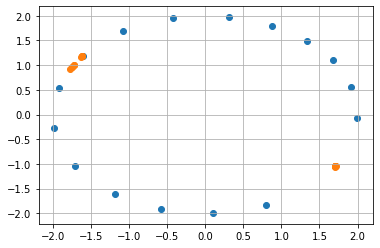

In [43]:
# ploting constellation diagram
import matplotlib.pyplot as plt
scatter_plot1 = scatter_plot1.reshape(M,2,1)
scatter_plot2 = scatter_plot2.reshape(M,2,1)
plt.scatter(scatter_plot1[:,0],scatter_plot1[:,1])
plt.scatter(scatter_plot2[:,0],scatter_plot2[:,1])
#plt.axis((-2.5,2.5,-2.5,2.5))
plt.grid()
plt.show()

In [44]:
# calculating BER
# this is optimized BER function so it can handle large number of N
# previous code has another for loop which was making it slow
EbNodB_range = list(np.arange(0,20+1,2))
ber1 = [None]*len(EbNodB_range)
ber2 = [None]*len(EbNodB_range)
for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = N
    noise1 = noise_std*np.random.randn(nn,2*n_channel)
    noise2 = noise_std*np.random.randn(nn,2*n_channel)
    encoded_signal1 = encoder1.predict(test_data1)
    encoded_signal2 = encoder2.predict(test_data2)
    final_signal1 = encoded_signal1+encoded_signal2+noise1
    final_signal2 = encoded_signal2+encoded_signal1+noise2
    pred_final_signal1 =  decoder1.predict(final_signal1)
    pred_final_signal2 =  decoder2.predict(final_signal2)
    pred_output1 = np.argmax(pred_final_signal1,axis=1)
    pred_output2 = np.argmax(pred_final_signal2,axis=1)
    no_errors1 = (pred_output1 != test_label[:,0])
    no_errors2 = (pred_output2 != test_label[:,1])
    no_errors1 =  no_errors1.astype(int).sum()
    no_errors2 =  no_errors2.astype(int).sum()
    ber1[n] = no_errors1 / nn 
    ber2[n] = no_errors2 / nn
    print ('SNR:',EbNodB_range[n],'BER1:',ber1[n],'BER2:',ber2[n])

SNR: 0 BER1: 0.39794 BER2: 0.86545
SNR: 2 BER1: 0.29107 BER2: 0.86171
SNR: 4 BER1: 0.19758 BER2: 0.8545
SNR: 6 BER1: 0.11696 BER2: 0.84822
SNR: 8 BER1: 0.06328 BER2: 0.84272
SNR: 10 BER1: 0.02983 BER2: 0.83575
SNR: 12 BER1: 0.01355 BER2: 0.83276
SNR: 14 BER1: 0.00514 BER2: 0.82807
SNR: 16 BER1: 0.00212 BER2: 0.82508
SNR: 18 BER1: 0.0006 BER2: 0.82255
SNR: 20 BER1: 0.00016 BER2: 0.82091


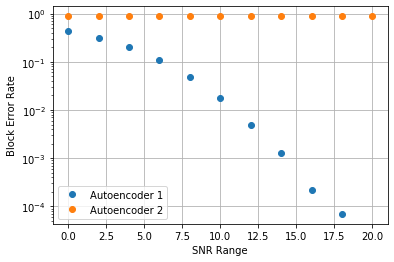

In [18]:
# ploting ber curve
import matplotlib.pyplot as plt
from scipy import interpolate
fig = plt.figure()
plt.plot(EbNodB_range, ber1, 'o',label='Autoencoder 1')
plt.plot(EbNodB_range, ber2, 'o',label='Autoencoder 2')
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(loc='lower left',ncol = 1)
plt.show()
#fig.savefig('stantard_loss_mimo.png')

In [50]:
test.alpha

<tf.Tensor 'loss_5/concatenate_12_loss/truediv_2:0' shape=(?,) dtype=float32>